In [463]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(4000)

### data preparation

In [67]:
#read data
X=pd.read_csv('.\\alternative_data_set\\X_diesel.csv',header=None)
Y=pd.read_csv('.\\alternative_data_set\\Y3_diesel.csv',header=None)

In [68]:
#remove missing values
X['target_variable']=Y[1]
X=X.dropna()
X=X.reset_index(drop=True)
Y=X.iloc[:,401]
X=X.iloc[:,:401]

In [69]:
#data split and normalisation
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

#train 0.8
#test 0.2

#norm
scaler_x = StandardScaler()
scaler_x.fit(x_train)
x_train=scaler_x.transform(x_train)
x_test=scaler_x.transform(x_test)

scaler_y=StandardScaler()
scaler_y.fit(y_train.values.reshape(-1,1))
y_train=scaler_y.transform(y_train.values.reshape(-1,1))
y_test=scaler_y.transform(y_test.values.reshape(-1,1))

In [70]:
x_train=pd.DataFrame(x_train)
y_train=pd.Series(y_train.ravel())

x_test=pd.DataFrame(x_test)
y_test=pd.Series(y_test.ravel())

### model class and train|evaluate functions

In [283]:
#convert, pandas to loader
def make_loader(X,y,batch):
    x_tensor=torch.tensor(X.values, dtype=torch.float32)
    y_tensor=torch.tensor(y.values, dtype=torch.float32)
    set_object=TensorDataset(x_tensor,y_tensor)
    loader_object=DataLoader(dataset=set_object,batch_size=batch)
    return loader_object

In [284]:
#NN class
class NeuralNetwork(nn.Module):
    def __init__(self,input_size):
        super(NeuralNetwork,self).__init__()
        
        self.linear_tanh_stack=nn.Sequential(
            nn.Linear(input_size,4),
            nn.Tanh(),
            nn.Linear(4,4),
            nn.Tanh(),
            nn.Linear(4,1)
        )
        
    def forward(self,x):
        forward_pass=self.linear_tanh_stack(x)
        return forward_pass

In [285]:
#evaluate once
def evaluate(Loader, model, loss_fn):
    model.eval()
    loss_sum=0
    with torch.no_grad():
        for batch, (X,y) in enumerate(Loader):
            pred=model(X)
            loss=loss_fn(pred,y.unsqueeze(1))
            loss_sum+=loss.item()
            
    loss_sum/=len(Loader)
    
    return loss_sum

In [286]:
#train and store all errors =)
def train(TrainLoader, TestLoader, model, loss_fn, optimizer,epochs):
    train_loss_epochs=[]
    test_loss_epochs=[]
    
    for epoch in range(epochs):
        model.train() 
        #train for every example in the dataloader
        for X_train,y_train in TrainLoader:
            
            pred_train=model(X_train)
            loss_train=loss_fn(pred_train,y_train.unsqueeze(1))
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
    
        loss_train_curr_epoch=evaluate(TrainLoader,model,loss_fn)
        train_loss_epochs.append(loss_train_curr_epoch)
       
        loss_test_curr_epoch=evaluate(TestLoader,model,loss_fn)
        test_loss_epochs.append(loss_test_curr_epoch)
        
    return model, train_loss_epochs, test_loss_epochs

### Loss plot

In [468]:
torch.manual_seed(4000)
train_loader=make_loader(X=x_train,y=y_train,batch=32)
test_loader=make_loader(X=x_test,y=y_test,batch=32)

model=NeuralNetwork(input_size=401)

loss_fn=nn.MSELoss()
optimizer=optim.Adam(model.parameters())

In [469]:
epochs=254
model, train_loss, test_loss=train(TrainLoader=train_loader,
                                   TestLoader=test_loader, 
                                   model=model, 
                                   loss_fn=loss_fn, 
                                   optimizer=optimizer,
                                   epochs=epochs)

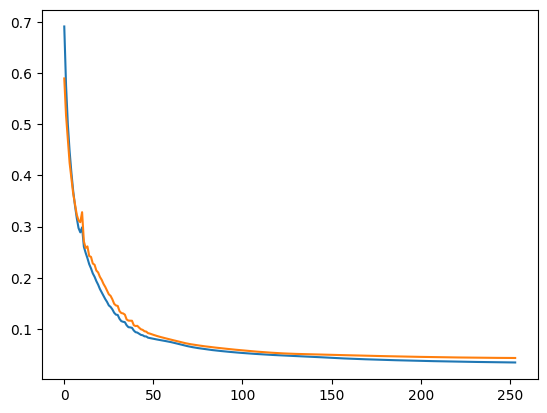

In [470]:
plt.plot(np.arange(epochs),train_loss)
plt.plot(np.arange(epochs),test_loss)
#plt.xlim(200,260)
#plt.ylim(0.02,0.2)

### permutation importance

In [461]:
#permutation importance from scikitlearn internally uses the predict function and checks for the presence
#of the fit function. if i feed my pytorch model inside a wrapper it works
class PyTorchRegressorWrapper:
    def __init__(self, model):
        model = model

    def fit(self, X, y):
        #this function only needs to exhist to fulfill API contract with scikitlearn
        pass

    def predict(self, X):
        model.eval()
        with torch.no_grad():
            #convert to numpy as needed
            if isinstance(X, pd.DataFrame):
                X = X.to_numpy()

            X_tensor = torch.tensor(X, dtype=torch.float32)
            predictions = model(X_tensor).numpy()
        return predictions

In [456]:
# pass model trough wrapper
model_wrapper = PyTorchRegressorWrapper(model=model)

# permutation importance with the wrapper instance
results = permutation_importance(model_wrapper,
                                 x_train,
                                 y_train,
                                 n_repeats=30,
                                 random_state=42,
                                 n_jobs=4,
                                 scoring='neg_mean_squared_error')

In [457]:
def perm_imp_get_topn_indexes(perm_imp_output,top_n):
    importance=perm_imp_output.importances_mean
    
    importance=pd.DataFrame(importance)
    importance_sorted=importance.sort_values(by=0, ascending=False)
    
    bestn=importance_sorted.head(top_n)
    values=bestn.index
    
    return values

In [ ]:
#function do achieve permutation importance with cross validation

for fold, (train_fold, val_fold) in enumerate()


In [458]:
values=perm_imp_get_topn_indexes(results,20)